# Model Evaluation process

-    After training our model we evaluate our results against ground truth values. Given that we are facing with an object detection problem, we are using a common metric called Average Precision(AP) and the mAP, which is the mean of the obtained APs from all classes. We calculate these metrics using the evaluation tools from the paper: "A Survey on Performance Metrics for Object-Detection Algorithms", available on the following link:
https://github.com/rafaelpadilla/Object-Detection-Metrics. 

-    In order to use them we should download the repo and follow installation instructions.

-    Once installed, we need two create two folders 'groundtruths' and 'detections' containing txt files for every sample considered for evaluation with the following format:


    - Line format for groundtruth files: 
                class_name xmin ymin xmax ymax
    - Line format for detection files:
                class_name confidence_score xmin ymin xmax ymax
                
                
                
-    We will perform the whole evaluation process in 3 steps:

    1. The first step is to write txt evaluation files with ground truth information for every sample using XML Annotations as a reference, under groundtruths folder.
            
    2. Second step consists on running the trained YOLO network to perform inference on selected samples and then writing txt files using their corresponding outputs.        
            
    4. Finally, using txt files to calculate AP values between ground truths and our detections.



# 1. Writting txt ground truth files

-     Our evaluation metrics will be obtained comparing the ground truth objects and confidence scores against our predictions. For that we need to create .txt files using the XML Annotations.

In [1]:
import os
from os import listdir
from os.path import isfile, join
import lxml.etree
import tqdm

- First, we declare the path of the folder where we copied all XML Annotation files from validation samples. We also declare the path for storing the ground truth files:

In [2]:
annotations = 'data/voc2012_raw/VOCdevkit/VOC2012/AnnotationsVal'
groundtruths = 'data/voc2012_raw/VOCdevkit/VOC2012/groundtruths'

- We store filenames from validation samples under annotations_list

In [3]:
annotations_list = [file for file in listdir(annotations) if isfile(join(annotations, file))]

In [4]:
annotations_list[:3]

['2020_92.xml', '2020_02_144.xml', '2020_02_203.xml']

- Now we define a function for traversing an xml file and returning its content on a dictionary:

In [5]:
def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != "object":
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

- We declare a function build_example for accesing the class names and bounding box coordinates from a dictionary generated by the parse_xml function, and then storing the result on a txt file file_tmp under the groundtruths directory.


- Let's remember that every line on the groundtruth .txt files should follow the following format:
        
                                    class_name xmin ymin xmax ymax

In [6]:
def build_example(name,annotation, class_map):
    file_name = join(groundtruths, name[:-4] + '.txt')
    file_tmp = open(file_name,'w')
    
    if "object" in annotation:
        for obj in annotation["object"]:  
            #we skip this class because we didnt optimize the network for this case, only for with_mask and without_mask classes
            if obj['name'] == 'mask_weared_incorrect': 
                continue
            line = obj["name"] +  ' ' + str(int(obj["bndbox"]["xmin"])) + ' ' + str(int(obj["bndbox"]["ymin"]))+ ' '+ str(int(obj["bndbox"]["xmax"])) + ' ' + str(int(obj["bndbox"]["ymax"]))
            #Writing into file_tmp
            print(line,file=file_tmp)
    
    file_tmp.close()
     

- Now we load class names from the voc2012.names file, and create a dictionary mapping class names to class ids

In [7]:
classes = 'data/voc2012.names'
class_map = {
    name: idx for idx, name in enumerate(open(classes).read().splitlines())
}

- Finally, we iterate over every file stored on annotations_list. First we read the file, then we parse the content from the xml, we access the objects under the 'annotation' key and read its contents to write the ground truth files into the corresponding folder:

In [8]:
for i,image in enumerate(annotations_list):
        if (i%50)==0:
            print('Image ',i)
        name = image
        annotation_xml = os.path.join(annotations, name)
        annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
        annotation = parse_xml(annotation_xml)["annotation"]
        build_example(name,annotation, class_map)

Image  0
Image  50
Image  100
Image  150
Image  200
Image  250
Image  300
Image  350
Image  400
Image  450
Image  500
Image  550
Image  600


- Now we can find a ground truth txt file for every sample used in the evaluation process inside the grountruths directory.

# 2. Writing detection files from YOLO output

- Now we need to store Yolo detections into txt files under the detections directory. We will also have a separate txt file per sample with its detections.

- The transformation will be done by the **write_detection** function:

- Let's remember that every line on these txt files should follow the following format:
        
                              class_name confidence_score xmin ymin xmax ymax

In [9]:
def write_detections(filename,img,boxes,scores,classes,nums):  
    file_tmp = open(detections + filename + '.txt','w')
    boxes, scores, classes, nums = boxes[0], scores[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        class_name = class_names[int(classes[i])]
        line = class_name +  ' ' + str(x1y1[0]) + str(x1y1[1]) + str(x2y2[0]) + str(x2y2[1])
        file_tmp.write(line)
    file_tmp.close()

- Now it's time to use the write_detections functions on our predictions. For that, we need to initialize YOLO architecture and perform inference on our samples.

# 3. Inference using trained model

- Our best trained model was obtained on epoch 125. We are using those weights to perform inference:

In [10]:
WEIGHTS = 'checkpoints/yolov3_train_125.tf'

- Model definition

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', WEIGHTS,
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

#LOAD WEIGHTS AND CREATE MODEL
FLAGS.num_classes = 3
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = WEIGHTS
FLAGS.tiny = False

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

app._run_init(['yolov3'], app.parse_flags_with_usage)

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

- Now we read val.txt file to extract validation filenames for inference:

In [ ]:
path_val =  'data/voc2012_raw/VOCdevkit/VOC2012/ImageSets/Main/'
val = open(path_val + 'val.txt',"r")
Lines = val.readlines() 
names_val = []
for line in Lines: 
    name = line.split()[0]
    names_val.append(name)

- Now we iterate through the samples stored on names_val and perform inference using the previously trained weights. After every iteration, we use inference outputs to write the detection files using **write_eval_file** funtion.

In [ ]:
from IPython.display import Image, display
from yolov3_tf2.utils import draw_outputs

import os

#path for loading images for inference
image_path = 'data/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/'
names = names_val

for i, filename in enumerate(names):
  if (i%50) == 0:
    print("Image ",i)
    print(image_path + FLAGS.image)

  FLAGS.image = filename + '.png'
  try:  
    img_raw = tf.image.decode_image(
        open(image_path + FLAGS.image, 'rb').read(), channels=3)
  except:
    try:
      FLAGS.image = filename + '.jpg'
      img_raw = tf.image.decode_image(
        open(image_path + FLAGS.image, 'rb').read(), channels=3)
    except:
      try:
        FLAGS.image = filename + '.jpeg'
        img_raw = tf.image.decode_image(
        open(image_path + FLAGS.image, 'rb').read(), channels=3)
      except:
        print("wrong image")
        continue

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  
  boxes, scores, classes, nums = yolo(img) #performing inference on an image
  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  write_detections(filename,img,boxes,scores,classes,nums) #writting inference file from predictions

# Evaluating predictions

- At this point we have both 'groundtruth', as well as 'detections' directories containing .txt files for the final evaluation. As we mentioned on the beggining, after installing the Object Detection Metrics repo, we perform evaluation with the following command:


                                        python pascalvoc.py -t 0.3
- Where t=0.3 is the evaluation threshold.


- We can observe evaluation results for classes with_mask and without_mask:

**Average Precision (AP) per class**:

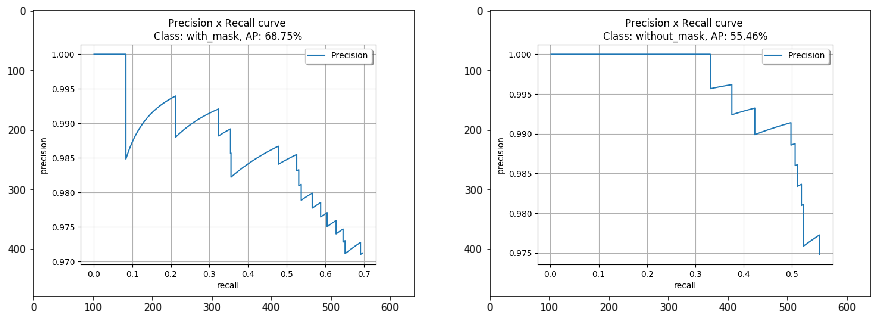

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig=plt.figure(figsize=(15, 15))
columns = 2
rows = 1

images = ['with_mask','without_mask']
for i in range(1, columns*rows +1):
    img=mpimg.imread('./' + images[i-1] + '.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

Results:


**AP with_mask: 68.75%**


**AP without_mask: 55.46%**

- We note that the axis from the AP plots for each class are: recall on the y axis and precision on the x axis. In order to better understand this metrics we need to define precision and recall:

**Precision**: Fraction correctly predicted positive samples.

**Recall**: Fraction of correctly predicted samples from the set of all positive samples.

- There is a tradeoff between precision and recall, and depending on our threshold for classifying a sample being positive or negative, we can obtain different precision recall values.


**Precision - Recall trade-off example**: If we set a very high treshold for predicting positive samples, we will obtain a very high precision given that the fraction of correctly predicted positive samples is going to be high due to a harder constrain imposed by the threshold. On the other hand recall is low, because that fraction of positive predicted samples is small compared to all positive samples from the ground truth.


**mAP (Mean Average Precision)**: mAP, is as the name says the mean of AP values from all classes, in this case:

In [14]:
AP_with_mask = 68.75
AP_without_mask = 55.46
mAP = (AP_with_mask + AP_without_mask)/2
print('mAP score: ',round(mAP,2),'%')

mAP score:  62.11 %
